In [1]:
import hashlib
import requests
import datetime
import pandas as pd
from IPython.display import HTML

Queremos que consultes a la api para que te devuelva la info de los personajes de marvel que empiecen por la inicial de tu nombre. Deberemos guardarlos en un csv la información con la siguiente estructura

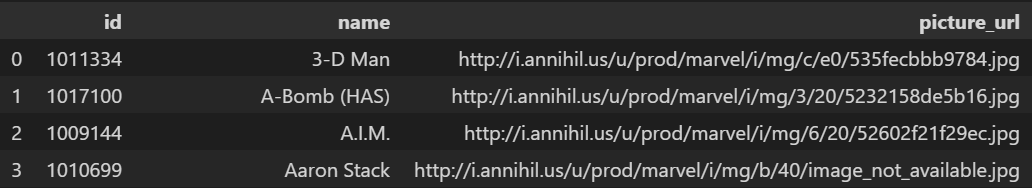

In [2]:
def hash_params(timestamp,priv_key,pub_key):
    """ Marvel API requires server side API calls to include
    md5 hash of timestamp + public key + private key """

    hash_md5 = hashlib.md5()
    hash_md5.update(f'{timestamp}{priv_key}{pub_key}'.encode('utf-8'))
    hashed_params = hash_md5.hexdigest()

    return hashed_params

In [3]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d%H:%M:%S')

pub_key = '76416694f55964f82f3a51d486d4fc04'
priv_key = '9aca74671cced72ee7efd35e4c621e08cc65c016'

params = {'ts': timestamp, 
        'apikey': pub_key, 
        'hash': hash_params(timestamp,priv_key,pub_key),
        # 'nameStartsWith':"",
        # 'offset':,
        # 'limit': 100,
        'name':'hulk'
        }

url = 'http://gateway.marvel.com/v1/public/characters'

res = requests.get(url,params=params)
res.json()

{'code': 200,
 'status': 'Ok',
 'copyright': '© 2024 MARVEL',
 'attributionText': 'Data provided by Marvel. © 2024 MARVEL',
 'attributionHTML': '<a href="http://marvel.com">Data provided by Marvel. © 2024 MARVEL</a>',
 'etag': 'dff92b2e296f3dc47705266b0dc441bb527845a7',
 'data': {'offset': 0,
  'limit': 20,
  'total': 1,
  'count': 1,
  'results': [{'id': 1009351,
    'name': 'Hulk',
    'description': 'Caught in a gamma bomb explosion while trying to save the life of a teenager, Dr. Bruce Banner was transformed into the incredibly powerful creature called the Hulk. An all too often misunderstood hero, the angrier the Hulk gets, the stronger the Hulk gets.',
    'modified': '2020-07-21T10:35:15-0400',
    'thumbnail': {'path': 'http://i.annihil.us/u/prod/marvel/i/mg/5/a0/538615ca33ab0',
     'extension': 'jpg'},
    'resourceURI': 'http://gateway.marvel.com/v1/public/characters/1009351',
    'comics': {'available': 1809,
     'collectionURI': 'http://gateway.marvel.com/v1/public/charac

In [4]:
# Función para obtener personajes
def obtener_personajes(url, params):
    res = requests.get(url, params=params)
    res.raise_for_status()
    return res.json()

# Función para almacenar los datos en un DataFrame
def almacenar_dataframe(respuesta):
    marvel_dict = {
        "id": [x.get('id') for x in respuesta['data']['results']],
        "name": [x.get('name') for x in respuesta['data']['results']],
        "picture_url": [
            f"{x.get('thumbnail').get('path')}.{x.get('thumbnail').get('extension')}" 
            for x in respuesta['data']['results']
        ]
    }
    df = pd.DataFrame(marvel_dict)
    # Añadir columna HTML para imágenes
    df['Image'] = df['picture_url'].apply(lambda url: f'<img src="{url}" style="height:100px;">')
    return df

# Función para obtener y guardar personajes por letra
def guardar_personajes_letra(letra):
    params = {
        'ts': timestamp,
        'apikey': pub_key,
        'hash': hash_params(timestamp, priv_key, pub_key),
        'nameStartsWith': letra,
        'offset': 0,
        'limit': 100
    }
    url = 'http://gateway.marvel.com/v1/public/characters'

    respuesta = obtener_personajes(url, params)
    df = almacenar_dataframe(respuesta)

    # Iterar para obtener todos los personajes si hay más de 100
    while len(df) < respuesta['data']['total']:
        print("Faltan aún datos por obtener")
        params['offset'] += 100
        respuesta = obtener_personajes(url, params)
        df = pd.concat([df, almacenar_dataframe(respuesta)], ignore_index=True)

    return df

In [6]:
# Obtener personajes que comienzan con 'h'
df_h = guardar_personajes_letra('K')

# Mostrar DataFrame con imágenes en Jupyter
HTML(df_h.to_html(escape=False))

,id,name,picture_url,Image
0,1011081,Ka-Zar,http://i.annihil.us/u/prod/marvel/i/mg/9/40/4dcc503738d3d.jpg,
1,1011193,Kabuki,http://i.annihil.us/u/prod/marvel/i/mg/b/40/image_not_available.jpg,
2,1009384,Kang,http://i.annihil.us/u/prod/marvel/i/mg/4/30/52695ed19538d.jpg,
3,1014983,Karen O'Malley,http://i.annihil.us/u/prod/marvel/i/mg/9/b0/4cd05c8be4587.jpg,
4,1011357,Karen Page,http://i.annihil.us/u/prod/marvel/i/mg/b/40/image_not_available.jpg,
5,1011386,Karma,http://i.annihil.us/u/prod/marvel/i/mg/5/00/50febe78aacca.jpg,
6,1009385,Karnak,http://i.annihil.us/u/prod/marvel/i/mg/9/c0/52740e5d96fcc.jpg,
7,1010752,Karolina Dean,http://i.annihil.us/u/prod/marvel/i/mg/d/50/4c00377435871.jpg,
8,1010783,Kat Farrell,http://i.annihil.us/u/prod/marvel/i/mg/b/40/image_not_available.jpg,
9,1010810,Kate Bishop,http://i.annihil.us/u/prod/marvel/i/mg/6/60/4c0035f5b8c95.jpg,
